# Convolutional Neural Networks

## Imports and constants

In [36]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
import shutil
import subprocess
import webbrowser
import time
import matplotlib.pyplot as plt
import csv

import torch.nn.init as init
import numpy as np

import matplotlib.patches as mpatches
from sklearn.manifold import TSNE





TENSORBOARD = False
TSNE = True
EPOCHS = 12
models_path = 'models'
plots_path = 'graphs'
runs_path = 'runs'

## Load data & initial preprocessing

In [10]:
'''
#1 Download the FashionMNIST train and test datasets

#2 Compute the mean and std of train images

#3 Define transformations:
  -ToTensor: Converts images to tensors
  -Normalise: Normalizes images to have mean 0 and std 1

#4 Apply transforms to the train and test datasets
Train dataset:
  -RandomRotation: Randomly rotates the images only 10 degrees to add some variation without 
  changing significantly the uniformality of the dataset.
  -RandomHorizontalFlip: Randomly flips 20% of the images horizontally . . .
  -RandomResizedCrop: Randomly zooming into or cropping the images to help the model focus on different parts of the image.

#5 Split the train set into training and validation sets

#6 Create iterators for our datasets using DataLoader

#7 Select device for training. Selects GPU or MPS if available, otherwise uses CPU.

#8 Index dataset's labels to image descriptors
'''

#1
train_set_full = datasets.FashionMNIST( root='./datasets/', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.FashionMNIST(root='./datasets', train=False, download=True, transform=transforms.ToTensor())

#2
imgs = torch.stack([img for img, _ in train_set_full], dim=0)
mean = imgs.mean()
std = imgs.std()

#3
train_val_set_transforms_aug = transforms.Compose([
                                      #  transforms.ColorJitter(brightness=0.5),
                                       transforms.RandomRotation(degrees=10),
                                      #  transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                       #  transforms.RandomGrayscale(p=0.2),
                                       transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                      ]
                                      )

test_set_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                      ])

#4
train_val_dataset = datasets.FashionMNIST(root="./datasets/", train=True, download=True, transform=train_val_set_transforms_aug)
test_dataset = datasets.FashionMNIST(root="./datasets/", train=False, download=True, transform=test_set_transforms)


#5
train_size = int(0.8 * len(train_val_dataset))
validation_size = len(train_val_dataset) - train_size
train_set, validation_set = random_split(train_val_dataset, [train_size, validation_size])

#6
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#7
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#8
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Using cpu device


In [11]:
# If tensorboard and there is a "runs" folder, delete it to start over
if TENSORBOARD:
    def delete_folder(folder_path):
        # Check if the folder exists
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            # Delete the folder
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_path}' has been deleted.")
        else:
            print(f"Folder '{folder_path}' does not exist.")

    folder_to_delete = runs_path
    delete_folder(folder_to_delete)

In [13]:
# Decreasing learning rate function
def decrease_lr(model,rate):
    print(f"lr decreased from {rate}, to {rate/2}")
    return optim.Adam(model.parameters(), lr=rate/2)

## LENet baseline

### Define the LeNet model

In [29]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extraction = nn.Sequential(
              #1
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),   # 28x28 -> 24x24
              nn.Tanh(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 24x24 -> 12x12

              #2
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 12x12 -> 8x8
              nn.Tanh(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*4*4, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()

    def forward(self, x):
        return self.classifier(self.feature_extraction(x))

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the feature extraction layers
        x = self.feature_extraction(x)

        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [30]:
model_lenet5 = LeNet5()

summary(model=model_lenet5, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature_extraction)        [1, 1, 28, 28]       [1, 16, 4, 4]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 24, 24]       156                  True
│    └─Tanh (1)                          [1, 6, 24, 24]       [1, 6, 24, 24]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 24, 24]       [1, 6, 12, 12]       --                   --
│    └─Conv2d (3)                        [1, 6, 12, 12]       [1, 16, 8, 8]        2,416                True
│    └─Tanh (4)                          [1, 16, 8, 8]        [1, 16, 8, 8]        --                   --
│    └─AvgPool2d (5)                     [1, 16, 8, 8]        [1, 16, 4, 4]        --                   --
├─Sequential (classifi

In [21]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

### Train LeNet model

In [22]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

    # Start TensorBoard using subprocess
    tensorboard_process = subprocess.Popen(["tensorboard", "--logdir", "runs", "--port", "6007"])

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5 = model_lenet5.to(device)

history_lenet5 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}

EPOCHS = 12

epoch_count = 0

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v0, train_acc_v0 = 0.0, 0.0
    
    # Decrease the learning rate by 1/2
    if epoch_count%5 == 0 and epoch_count>0:
        optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])
    
    epoch_count += 1
    
    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5.train()
        # Forward pass: compute predictions
        y_pred = model_lenet5.forward(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v0 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v0 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()
        

    # Average training loss and accuracy over all batches
    train_loss_v0 /= len(train_loader)
    train_acc_v0 /= len(train_loader)
    # Keep history
    history_lenet5['train_loss'].append(train_loss_v0)
    history_lenet5['train_acc'].append(train_acc_v0)

    # Validation loop
    val_loss_v0, val_acc_v0 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model_lenet5(X)

            loss = loss_fn(y_pred, y)
            val_loss_v0 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v0 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v0 /= len(validation_loader)
        val_acc_v0 /= len(validation_loader)
        # Keep history
        history_lenet5['val_loss'].append(val_loss_v0)
        history_lenet5['val_acc'].append(val_acc_v0)

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss_v0, "val/loss": val_loss_v0}, global_step=epoch)
        writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc_v0, "val/acc": val_acc_v0}, global_step=epoch)

        if epoch == 0:
            # Optionally, open a web browser tab. The time delay allows TensorBoard to start up.
            time.sleep(3)  # Wait for 3 seconds before opening the browser
            webbrowser.open("http://localhost:6007")

    print(f"Epoch: {epoch}| Train loss: {train_loss_v0: .5f}| Train acc: {train_acc_v0: .5f}| Val loss: {val_loss_v0: .5f}| Val acc: {val_acc_v0: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.66767| Train acc:  0.74921| Val loss:  0.57313| Val acc:  0.78508
Epoch: 1| Train loss:  0.53290| Train acc:  0.79919| Val loss:  0.52804| Val acc:  0.79758
Epoch: 2| Train loss:  0.48505| Train acc:  0.81629| Val loss:  0.50174| Val acc:  0.81225
Epoch: 3| Train loss:  0.46096| Train acc:  0.82608| Val loss:  0.47949| Val acc:  0.81717
Epoch: 4| Train loss:  0.44355| Train acc:  0.83296| Val loss:  0.46024| Val acc:  0.82250
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.40682| Train acc:  0.84627| Val loss:  0.44359| Val acc:  0.83167
Epoch: 6| Train loss:  0.39793| Train acc:  0.85010| Val loss:  0.43024| Val acc:  0.83850
Epoch: 7| Train loss:  0.39087| Train acc:  0.85300| Val loss:  0.41302| Val acc:  0.84508
Epoch: 8| Train loss:  0.38515| Train acc:  0.85458| Val loss:  0.41373| Val acc:  0.84150
Epoch: 9| Train loss:  0.37822| Train acc:  0.85752| Val loss:  0.41104| Val acc:  0.84692
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

### t-SNE visualization

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


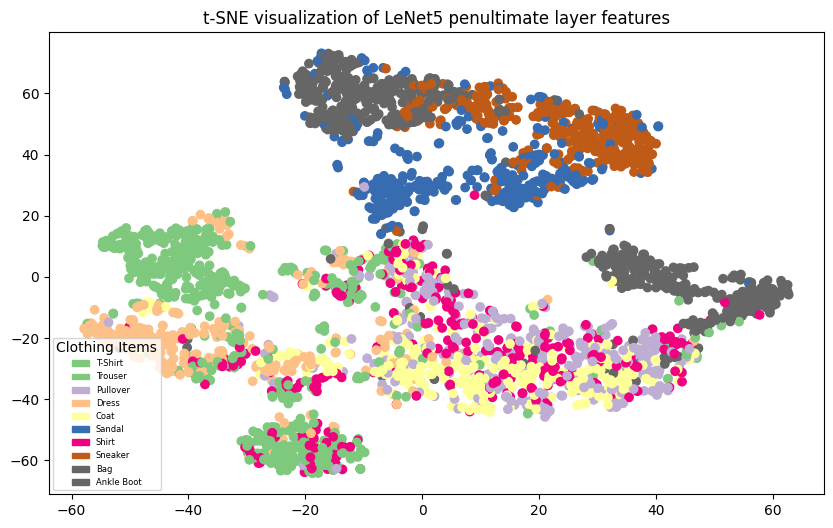

In [46]:
if TSNE:
    features = []
    labels_list = []

    model_lenet5.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            feature = model_lenet5.get_features(X)
            features.append(feature.cpu().numpy())
            labels_list.append(y.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    features = features[::3]
    labels = labels[::3]

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=123).fit_transform(features)

    # Create a color map with distinct colors for each label
    cmap = plt.cm.get_cmap('Accent', 10) 

    # Plotting
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap=cmap)
    plt.title("t-SNE visualization of LeNet5 penultimate layer features")

    # Create a legend
    handles = [mpatches.Patch(color=cmap(i), label=labels_map[i]) for i in range(10)]
    plt.legend(handles=handles, title="Clothing Items", fontsize="6", loc="lower left")

    plt.show()


In [52]:
def plot_train_val_metrics(history, model_name):
    plt.figure(figsize=(10, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', color='black')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy', color='black')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Add a main title for the whole figure
    plt.suptitle(f"Training and Validation Metrics for {model_name}", fontsize=16, y=1.05)

    # Adjust layout and show plot
    plt.tight_layout()
    
    # Save plot to file
    save_path = os.path.join(plots_path +'/', f"{model_name}_metrics.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()


In [53]:
def export_model(model, model_filename):
    model_scripted = torch.jit.script(model)  # Export to TorchScript
    save_path = os.path.join(models_path, model_filename + '.pt')
    model_scripted.save(save_path)  # Save the model

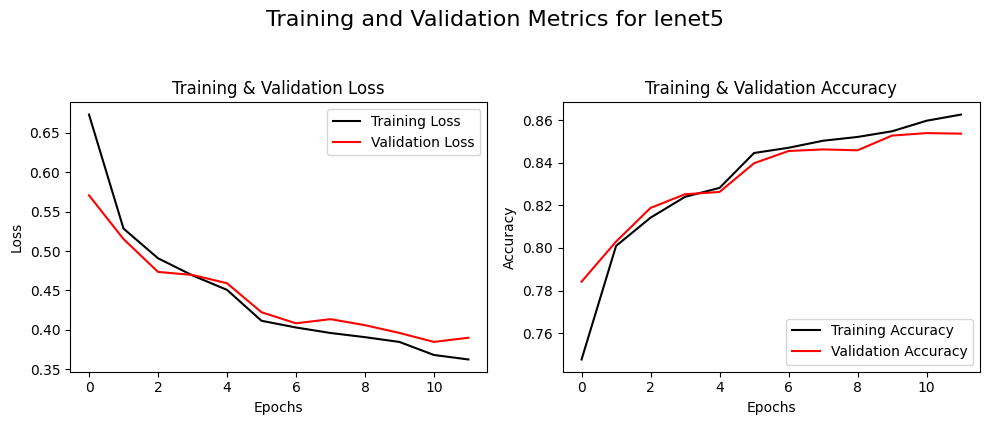

In [54]:
plot_train_val_metrics(history_lenet5, "lenet5")

In [55]:
export_model(model_lenet5, 'lenet5_model_original')

### Evaluation on the test set

In [56]:
test_loss, test_acc = 0, 0
# Same procedure with the validation set
model_lenet5.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model_lenet5(X)

        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.34283| Test acc:  0.87320


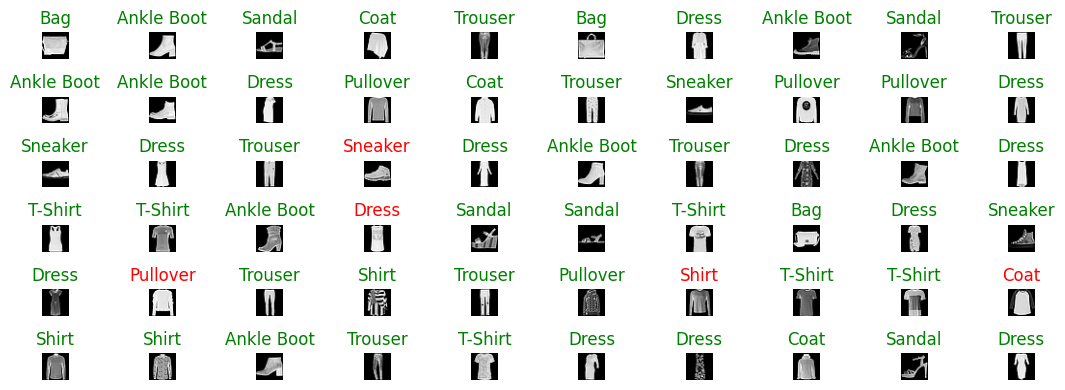

In [57]:
# See random images with their labels
torch.manual_seed(22)  # setting random seed
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 6, 10
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = int(torch.argmax(model_lenet5(img_temp)))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(labels_map[label_pred], color='g') # green label for correct prediction
    else:
        plt.title(labels_map[label_pred], color='r') # red label for incorrect prediction
    plt.axis(False)
    plt.tight_layout();

## Model variants

### 1st variant
Replace Tanh with ReLu

In [58]:
class LeNet5_v1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extraction = nn.Sequential(
              #1
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),   # 28*28-> 24*24
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 12*12

              #2
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 8*8
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 4*4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*4*4, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()

    def forward(self, x):
        return self.classifier(self.feature_extraction(x))
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [59]:
model_lenet5_v1 = LeNet5_v1()

summary(model=model_lenet5_v1, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v1 (LeNet5_v1)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature_extraction)        [1, 1, 28, 28]       [1, 16, 4, 4]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 24, 24]       156                  True
│    └─ReLU (1)                          [1, 6, 24, 24]       [1, 6, 24, 24]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 24, 24]       [1, 6, 12, 12]       --                   --
│    └─Conv2d (3)                        [1, 6, 12, 12]       [1, 16, 8, 8]        2,416                True
│    └─ReLU (4)                          [1, 16, 8, 8]        [1, 16, 8, 8]        --                   --
│    └─AvgPool2d (5)                     [1, 16, 8, 8]        [1, 16, 4, 4]        --                   --
├─Sequential (classifi

In [60]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v1.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

In [61]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v1"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v1 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v1 = model_lenet5_v1.to(device)

history_lenet5_v1 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}

EPOCHS = 12

epoch_count = 0

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v1, train_acc_v1 = 0.0, 0.0
    
    # Decrease the learning rate by 1/2
    if epoch_count%5 == 0 and epoch_count>0:
        optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v1.train()
        # Forward pass: compute predictions
        y_pred = model_lenet5_v1(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v1 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v1 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v1 /= len(train_loader)
    train_acc_v1 /= len(train_loader)
    # Keep history
    history_lenet5_v1['train_loss'].append(train_loss_v1)
    history_lenet5_v1['train_acc'].append(train_acc_v1)

    # Validation loop
    val_loss_v1, val_acc_v1 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v1.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model_lenet5_v1(X)

            loss = loss_fn(y_pred, y)
            val_loss_v1 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v1 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v1 /= len(validation_loader)
        val_acc_v1 /= len(validation_loader)
        # Keep history
        history_lenet5_v1['val_loss'].append(val_loss_v1)
        history_lenet5_v1['val_acc'].append(val_acc_v1)

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer_v1.add_scalars(main_tag="Loss_v1", tag_scalar_dict={"train_v1/loss_v1": train_loss_v1, "val_v1/loss_v1": val_loss_v1}, global_step=epoch)
        writer_v1.add_scalars(main_tag="Accuracy_v1", tag_scalar_dict={"train_v1/acc_v1": train_acc_v1, "val_v1/acc_v1": val_acc_v1}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v1: .5f}| Train acc: {train_acc_v1: .5f}| Val loss: {val_loss_v1: .5f}| Val acc: {val_acc_v1: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.69297| Train acc:  0.73752| Val loss:  0.55766| Val acc:  0.78617
Epoch: 1| Train loss:  0.52075| Train acc:  0.80144| Val loss:  0.48901| Val acc:  0.80783
Epoch: 2| Train loss:  0.47421| Train acc:  0.81979| Val loss:  0.46240| Val acc:  0.82192
Epoch: 3| Train loss:  0.44812| Train acc:  0.82912| Val loss:  0.44496| Val acc:  0.83450
Epoch: 4| Train loss:  0.42574| Train acc:  0.83848| Val loss:  0.41437| Val acc:  0.84233
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.40143| Train acc:  0.84654| Val loss:  0.42248| Val acc:  0.84058
Epoch: 6| Train loss:  0.40703| Train acc:  0.84571| Val loss:  0.41947| Val acc:  0.84058
Epoch: 7| Train loss:  0.40217| Train acc:  0.84752| Val loss:  0.41482| Val acc:  0.84150
Epoch: 8| Train loss:  0.40221| Train acc:  0.84833| Val loss:  0.41802| Val acc:  0.83883
Epoch: 9| Train loss:  0.40445| Train acc:  0.84608| Val loss:  0.42015| Val acc:  0.84033
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

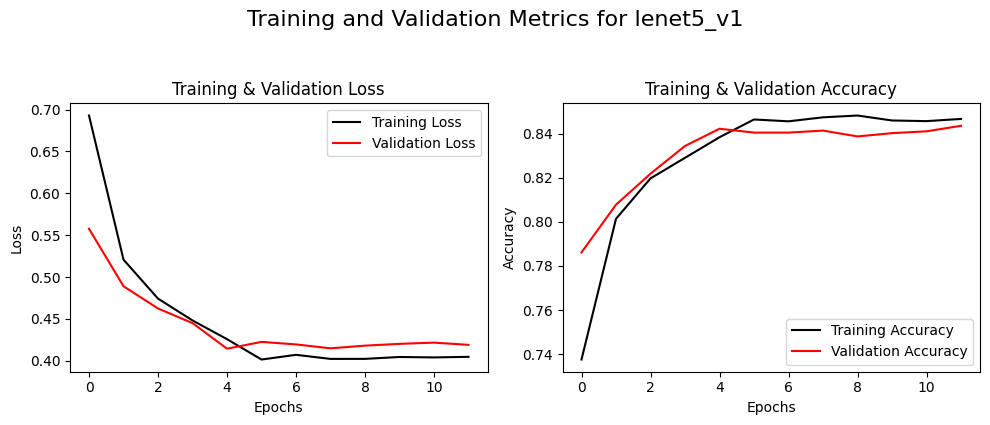

In [62]:
plot_train_val_metrics(history_lenet5_v1, "lenet5_v1")

In [63]:
export_model(model_lenet5_v1, 'lenet5_v1_model_')

### 2nd variant
Add dropout layers

In [64]:
class LeNet5_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extraction = nn.Sequential(
              #1
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),   # 28*28-> 24*24
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 12*12
              nn.Dropout(p=0.25),

              #2
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 8*8
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 4*4
              nn.Dropout(p=0.5)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*4*4, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()

    def forward(self, x):
        return self.classifier(self.feature_extraction(x))
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [65]:
model_lenet5_v2 = LeNet5_v2()

summary(model=model_lenet5_v2, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v2 (LeNet5_v2)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature_extraction)        [1, 1, 28, 28]       [1, 16, 4, 4]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 24, 24]       156                  True
│    └─ReLU (1)                          [1, 6, 24, 24]       [1, 6, 24, 24]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 24, 24]       [1, 6, 12, 12]       --                   --
│    └─Dropout (3)                       [1, 6, 12, 12]       [1, 6, 12, 12]       --                   --
│    └─Conv2d (4)                        [1, 6, 12, 12]       [1, 16, 8, 8]        2,416                True
│    └─ReLU (5)                          [1, 16, 8, 8]        [1, 16, 8, 8]        --                   --
│    └─AvgPool2d (6)  

In [66]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v2.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

In [67]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v2"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v2 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v2 = model_lenet5_v2.to(device)

history_lenet5_v2 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}

EPOCHS = 12

epoch_count = 0

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v2, train_acc_v2 = 0.0, 0.0
    
    # Decrease the learning rate by 1/2
    if epoch_count%5 == 0 and epoch_count>0:
        optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v2.train()
        # Forward pass: compute predictions
        y_pred = model_lenet5_v2(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v2 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v2 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v2 /= len(train_loader)
    train_acc_v2 /= len(train_loader)
    # Keep history
    history_lenet5_v2['train_loss'].append(train_loss_v2)
    history_lenet5_v2['train_acc'].append(train_acc_v2)

    # Validation loop
    val_loss_v2, val_acc_v2 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v2.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model_lenet5_v2(X)

            loss = loss_fn(y_pred, y)
            val_loss_v2 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v2 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v2 /= len(validation_loader)
        val_acc_v2 /= len(validation_loader)
        # Keep history
        history_lenet5_v2['val_loss'].append(val_loss_v2)
        history_lenet5_v2['val_acc'].append(val_acc_v2)

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer_v2.add_scalars(main_tag="Loss_v2", tag_scalar_dict={"train_v2/loss_v2": train_loss_v2, "val_v2/loss_v2": val_loss_v2}, global_step=epoch)
        writer_v2.add_scalars(main_tag="Accuracy_v2", tag_scalar_dict={"train_v2/acc_v24": train_acc_v2, "val_v2/acc_v2": val_acc_v2}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v2: .5f}| Train acc: {train_acc_v2: .5f}| Val loss: {val_loss_v2: .5f}| Val acc: {val_acc_v2: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.93010| Train acc:  0.65752| Val loss:  0.65193| Val acc:  0.74850
Epoch: 1| Train loss:  0.70034| Train acc:  0.73325| Val loss:  0.58672| Val acc:  0.77767
Epoch: 2| Train loss:  0.64984| Train acc:  0.75392| Val loss:  0.54905| Val acc:  0.79017
Epoch: 3| Train loss:  0.61814| Train acc:  0.76475| Val loss:  0.52437| Val acc:  0.79708
Epoch: 4| Train loss:  0.59073| Train acc:  0.77658| Val loss:  0.49806| Val acc:  0.80608
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.58045| Train acc:  0.77892| Val loss:  0.49583| Val acc:  0.80975
Epoch: 6| Train loss:  0.57845| Train acc:  0.77969| Val loss:  0.49892| Val acc:  0.80767
Epoch: 7| Train loss:  0.58281| Train acc:  0.77750| Val loss:  0.49622| Val acc:  0.81208
Epoch: 8| Train loss:  0.57982| Train acc:  0.77785| Val loss:  0.49606| Val acc:  0.81125
Epoch: 9| Train loss:  0.57872| Train acc:  0.78038| Val loss:  0.49771| Val acc:  0.80558
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

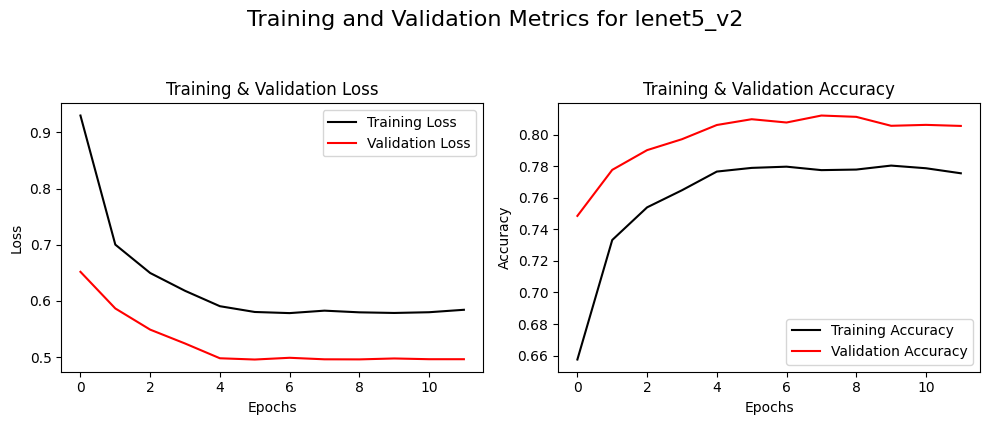

In [68]:
plot_train_val_metrics(history_lenet5_v2, "lenet5_v2")

In [69]:
export_model(model_lenet5_v2, 'lenet5_v2_model')

### 3rd variant
Modify convolutional layers

In [72]:
class LeNet5_v3(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extraction = nn.Sequential(
              #1
              nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),   # 28*28-> 24*24
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 12*12
              nn.Dropout(p=0.25),

              #2
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),  # 8*8
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 4*4
              nn.Dropout(p=0.5)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*4*4, out_features=240),
            nn.ReLU(),
            nn.Linear(in_features=240, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()

    def forward(self, x):
        return self.classifier(self.feature_extraction(x))
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [73]:
model_lenet5_v3 = LeNet5_v3()

summary(model=model_lenet5_v3, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v3 (LeNet5_v3)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature_extraction)        [1, 1, 28, 28]       [1, 32, 4, 4]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 16, 24, 24]      416                  True
│    └─ReLU (1)                          [1, 16, 24, 24]      [1, 16, 24, 24]      --                   --
│    └─AvgPool2d (2)                     [1, 16, 24, 24]      [1, 16, 12, 12]      --                   --
│    └─Dropout (3)                       [1, 16, 12, 12]      [1, 16, 12, 12]      --                   --
│    └─Conv2d (4)                        [1, 16, 12, 12]      [1, 32, 8, 8]        12,832               True
│    └─ReLU (5)                          [1, 32, 8, 8]        [1, 32, 8, 8]        --                   --
│    └─AvgPool2d (6)  

In [74]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v3.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

In [75]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v3"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v3 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v3 = model_lenet5_v3.to(device)

history_lenet5_v3 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}

EPOCHS = 12

epoch_count = 0

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v3, train_acc_v3 = 0.0, 0.0
    
    # Decrease the learning rate by 1/2
    if epoch_count%5 == 0 and epoch_count>0:
        optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v3.train()
        # Forward pass: compute predictions
        y_pred = model_lenet5_v3(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v3 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v3 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v3 /= len(train_loader)
    train_acc_v3 /= len(train_loader)
    # Keep history
    history_lenet5_v3['train_loss'].append(train_loss_v3)
    history_lenet5_v3['train_acc'].append(train_acc_v3)

    # Validation loop
    val_loss_v3, val_acc_v3 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v3.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model_lenet5_v3(X)

            loss = loss_fn(y_pred, y)
            val_loss_v3 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v3 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v3 /= len(validation_loader)
        val_acc_v3 /= len(validation_loader)
        # Keep history
        history_lenet5_v3['val_loss'].append(val_loss_v3)
        history_lenet5_v3['val_acc'].append(val_acc_v3)

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer_v3.add_scalars(main_tag="Loss_v3", tag_scalar_dict={"train_v3/loss_v3": train_loss_v3, "val_v3/loss_v3": val_loss_v3}, global_step=epoch)
        writer_v3.add_scalars(main_tag="Accuracy_v3", tag_scalar_dict={"train_v3/acc_v3": train_acc_v3, "val_v3/acc_v3": val_acc_v3}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v3: .5f}| Train acc: {train_acc_v3: .5f}| Val loss: {val_loss_v3: .5f}| Val acc: {val_acc_v3: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.77951| Train acc:  0.70642| Val loss:  0.55882| Val acc:  0.79308
Epoch: 1| Train loss:  0.59362| Train acc:  0.77608| Val loss:  0.50334| Val acc:  0.81658
Epoch: 2| Train loss:  0.53665| Train acc:  0.79706| Val loss:  0.45287| Val acc:  0.83133
Epoch: 3| Train loss:  0.50568| Train acc:  0.81031| Val loss:  0.42280| Val acc:  0.84067
Epoch: 4| Train loss:  0.48595| Train acc:  0.81735| Val loss:  0.40675| Val acc:  0.84300
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.46933| Train acc:  0.82119| Val loss:  0.40871| Val acc:  0.84608
Epoch: 6| Train loss:  0.47065| Train acc:  0.82383| Val loss:  0.40747| Val acc:  0.84458
Epoch: 7| Train loss:  0.46810| Train acc:  0.82421| Val loss:  0.40532| Val acc:  0.84308
Epoch: 8| Train loss:  0.46647| Train acc:  0.82517| Val loss:  0.40392| Val acc:  0.84458
Epoch: 9| Train loss:  0.46896| Train acc:  0.82292| Val loss:  0.41074| Val acc:  0.84083
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

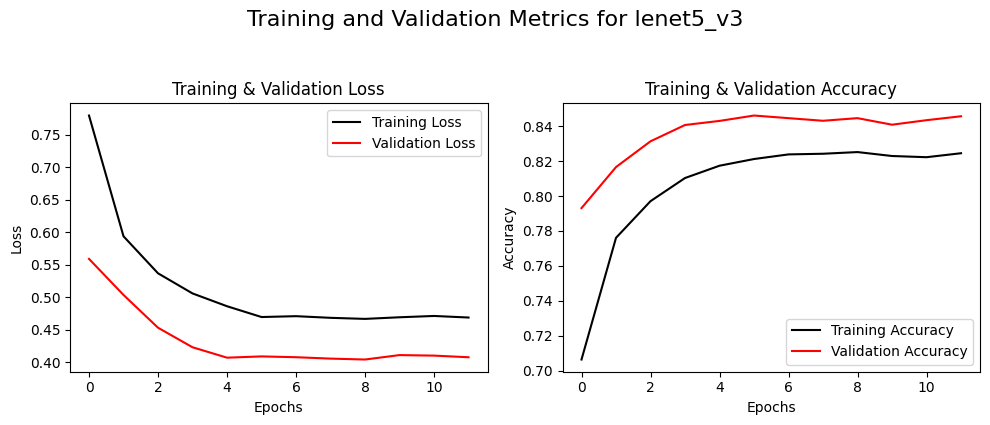

In [76]:
plot_train_val_metrics(history_lenet5_v3, "lenet5_v3")

In [77]:
export_model(model_lenet5_v3, 'lenet5_v3_model')

### 4th variant
L2 regularization

In [78]:
class LeNet5_v4(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extraction = nn.Sequential(
              #1
              nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1),   # 28*28-> 24*24
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 12*12
              nn.Dropout(p=0.25),

              #2
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),  # 8*8
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 4*4
              nn.Dropout(p=0.5)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*4*4, out_features=240),
            nn.ReLU(),
            nn.Linear(in_features=240, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()

    def forward(self, x):
        return self.classifier(self.feature_extraction(x))
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [79]:
model_lenet5_v4 = LeNet5_v4()

summary(model=model_lenet5_v4, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v4 (LeNet5_v4)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature_extraction)        [1, 1, 28, 28]       [1, 32, 4, 4]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 16, 24, 24]      416                  True
│    └─ReLU (1)                          [1, 16, 24, 24]      [1, 16, 24, 24]      --                   --
│    └─AvgPool2d (2)                     [1, 16, 24, 24]      [1, 16, 12, 12]      --                   --
│    └─Dropout (3)                       [1, 16, 12, 12]      [1, 16, 12, 12]      --                   --
│    └─Conv2d (4)                        [1, 16, 12, 12]      [1, 32, 8, 8]        12,832               True
│    └─ReLU (5)                          [1, 32, 8, 8]        [1, 32, 8, 8]        --                   --
│    └─AvgPool2d (6)  

In [80]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v4.parameters(), lr=0.001, weight_decay=1e-4)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

In [81]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v4"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v4 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v4 = model_lenet5_v4.to(device)

history_lenet5_v4 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}

EPOCHS = 12

epoch_count = 0

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v4, train_acc_v4 = 0.0, 0.0
    
    # Decrease the learning rate by 1/2
    if epoch_count%5 == 0 and epoch_count>0:
        optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v4.train()
        # Forward pass: compute predictions
        y_pred = model_lenet5_v4(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v4 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v4 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v4 /= len(train_loader)
    train_acc_v4 /= len(train_loader)
    # Keep history
    history_lenet5_v4['train_loss'].append(train_loss_v4)
    history_lenet5_v4['train_acc'].append(train_acc_v4)

    # Validation loop
    val_loss_v4, val_acc_v4 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v4.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model_lenet5_v4(X)

            loss = loss_fn(y_pred, y)
            val_loss_v4 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v4 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v4 /= len(validation_loader)
        val_acc_v4 /= len(validation_loader)
        # Keep history
        history_lenet5_v4['val_loss'].append(val_loss_v4)
        history_lenet5_v4['val_acc'].append(val_acc_v4)
        
    if TENSORBOARD:
    # Log training and validation loss and accuracy to TensorBoard
        writer_v4.add_scalars(main_tag="Loss_v4", tag_scalar_dict={"train_v4/loss_v4": train_loss_v4, "val_v4/loss_v4": val_loss_v4}, global_step=epoch)
        writer_v4.add_scalars(main_tag="Accuracy_v4", tag_scalar_dict={"train_v4/acc_v4": train_acc_v4, "val_v4/acc_v4": val_acc_v4}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v4: .5f}| Train acc: {train_acc_v4: .5f}| Val loss: {val_loss_v4: .5f}| Val acc: {val_acc_v4: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.76204| Train acc:  0.71363| Val loss:  0.54330| Val acc:  0.78608
Epoch: 1| Train loss:  0.58238| Train acc:  0.77860| Val loss:  0.49130| Val acc:  0.81383
Epoch: 2| Train loss:  0.53803| Train acc:  0.79798| Val loss:  0.46164| Val acc:  0.82367
Epoch: 3| Train loss:  0.51116| Train acc:  0.80721| Val loss:  0.44774| Val acc:  0.82792
Epoch: 4| Train loss:  0.49467| Train acc:  0.81463| Val loss:  0.41333| Val acc:  0.84108
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.47291| Train acc:  0.82140| Val loss:  0.41374| Val acc:  0.84300
Epoch: 6| Train loss:  0.47154| Train acc:  0.82294| Val loss:  0.41563| Val acc:  0.84242
Epoch: 7| Train loss:  0.47178| Train acc:  0.82169| Val loss:  0.41327| Val acc:  0.84000
Epoch: 8| Train loss:  0.47398| Train acc:  0.82252| Val loss:  0.41225| Val acc:  0.84242
Epoch: 9| Train loss:  0.47450| Train acc:  0.81967| Val loss:  0.41321| Val acc:  0.84092
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

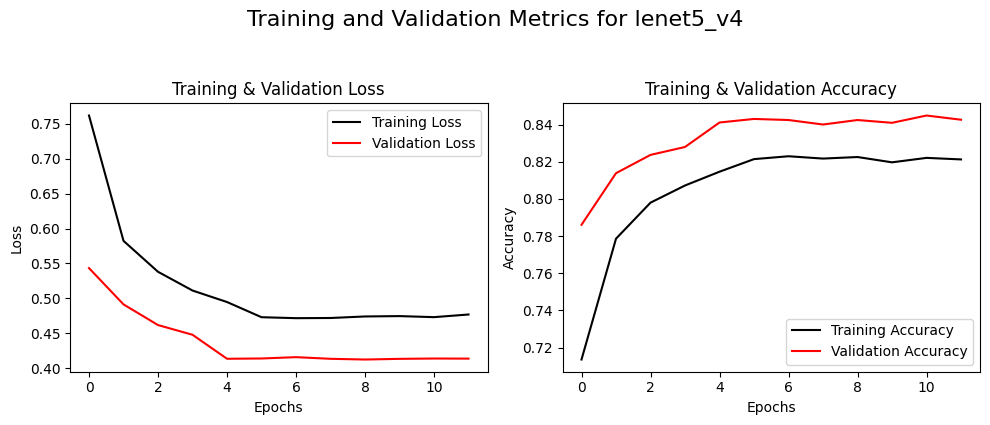

In [82]:
plot_train_val_metrics(history_lenet5_v4, "lenet5_v4")

In [83]:
export_model(model_lenet5_v4, 'lenet5_v4_model')

## Store results in CSV

In [84]:
model_metrics = {
    'model_original': {'train_loss': train_loss_v0, 'val_loss': val_loss_v0, 'train_acc': train_acc_v0, 'val_acc': val_acc_v0},
    'model_v1': {'train_loss': train_loss_v1, 'val_loss': val_loss_v1, 'train_acc': train_acc_v1, 'val_acc': val_acc_v1},
    'model_v2': {'train_loss': train_loss_v2, 'val_loss': val_loss_v2, 'train_acc': train_acc_v2, 'val_acc': val_acc_v2},
    'model_v3': {'train_loss': train_loss_v3, 'val_loss': val_loss_v3, 'train_acc': train_acc_v3, 'val_acc': val_acc_v3},
    'model_v4': {'train_loss': train_loss_v4, 'val_loss': val_loss_v4, 'train_acc': train_acc_v4, 'val_acc': val_acc_v4},
}

In [85]:
def create_csv(model_metrics, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        header = ['Model', 'Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy']
        writer.writerow(header)

        # Write the data for each model
        for model_name, metrics in model_metrics.items():
            row = [
                model_name,
                metrics['train_loss'],
                metrics['val_loss'],
                metrics['train_acc'].item() if torch.is_tensor(metrics['train_acc']) else metrics['train_acc'],
                metrics['val_acc'].item() if torch.is_tensor(metrics['val_acc']) else metrics['val_acc']
            ]
            writer.writerow(row)

In [86]:
create_csv(model_metrics, 'final_model_metrics.csv')
